In [24]:
from sklearn.preprocessing import StandardScaler

# SOM - CESM Member 001

#### Template from 'Basic uses of SOMPY library', modified for our use
http://www.vahidmoosavi.com

https://github.com/sevamoo/sompy

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
# import sompy as sompy
import pandas as pd
import numpy as np
from time import time
import sompy

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array
backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
import os
import numpy as np
import xarray as xr

In [3]:
import datetime

#### Prepare Data for Model
* Import data, view basic characteristics
* normalize
* Observe 2d abstraction of SOM results
* Extract cluster designations








In [5]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
#DATA_DIR = '/Users/cg/co2/'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [6]:
df = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


In [7]:
SOM_input = pd.concat([df['SSS'],df['MLD']['MLD'],df['SST']['SST'],df['pCO2']['pCO2']], axis=1)

In [8]:
SOM_input.shape
#SOM_input.head()

(17290470, 7)

In [9]:
#Filter out outliers, SSS
SOM_input = SOM_input.loc[SOM_input['SSS'] > 8]

### Note above: 15k outliers from SSS removed, see scatterplots
* Could further constrain data to improve model parameters, but 'lost' data may have more information we don't want to omit

In [57]:
SOM_sample = SOM_input.sample(200000)
SOM_sample = SOM_sample.reset_index(drop=True)

In [58]:
#log(MLD)
SOM_sample[['MLD']] = SOM_sample[['MLD']].apply(np.log)

# Scale Data

#### choice of normalization or transform? 
* would like to try sample runs both ways and evaluate performance 

In [25]:
#sample_scatter[['SSS','SST']] = StandardScaler().fit_transform(sample_scatter[['SSS','SST']])

In [59]:
ss = StandardScaler().fit_transform(SOM_sample[['SSS','SST','MLD','pCO2']])

In [60]:
ss.shape

(200000L, 4L)

In [61]:
#tuning parameters
#research suggests M = 5*sqrt(N) is a good choice for neurons
M = 5*np.sqrt(ss.shape[0])
M
#insert source

2236.0679774997898

In [ ]:
m=int(np.sqrt(M))
m

In [ ]:
#testing suggests pca is faster than random init but limits # of epochs/trainlen internal to SOM engine
#batch faster than sequential
mapsize = [3*m,3*m]
som = sompy.SOMFactory.build(ss, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', 
                             initialization='random', neighborhood='gaussian', 
                             training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything


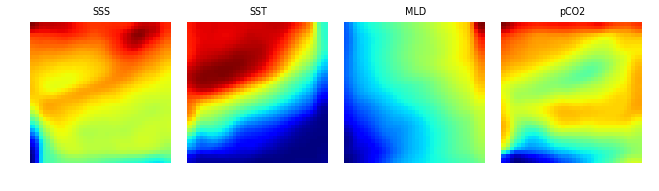

In [41]:
som.component_names = ['SSS','SST','MLD','pCO2']
v = sompy.mapview.View2DPacked(20, 20, '',text_size=8)  
v.show(som, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default


In [42]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(5, 2, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl = som.cluster(n_clusters=5)
# print cl
getattr(som, 'cluster_labels')

array([4, 4, 4, ..., 2, 2, 2])

C:\Users\goyetc\AppData\Local\Continuum\anaconda3\envs\sompy_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


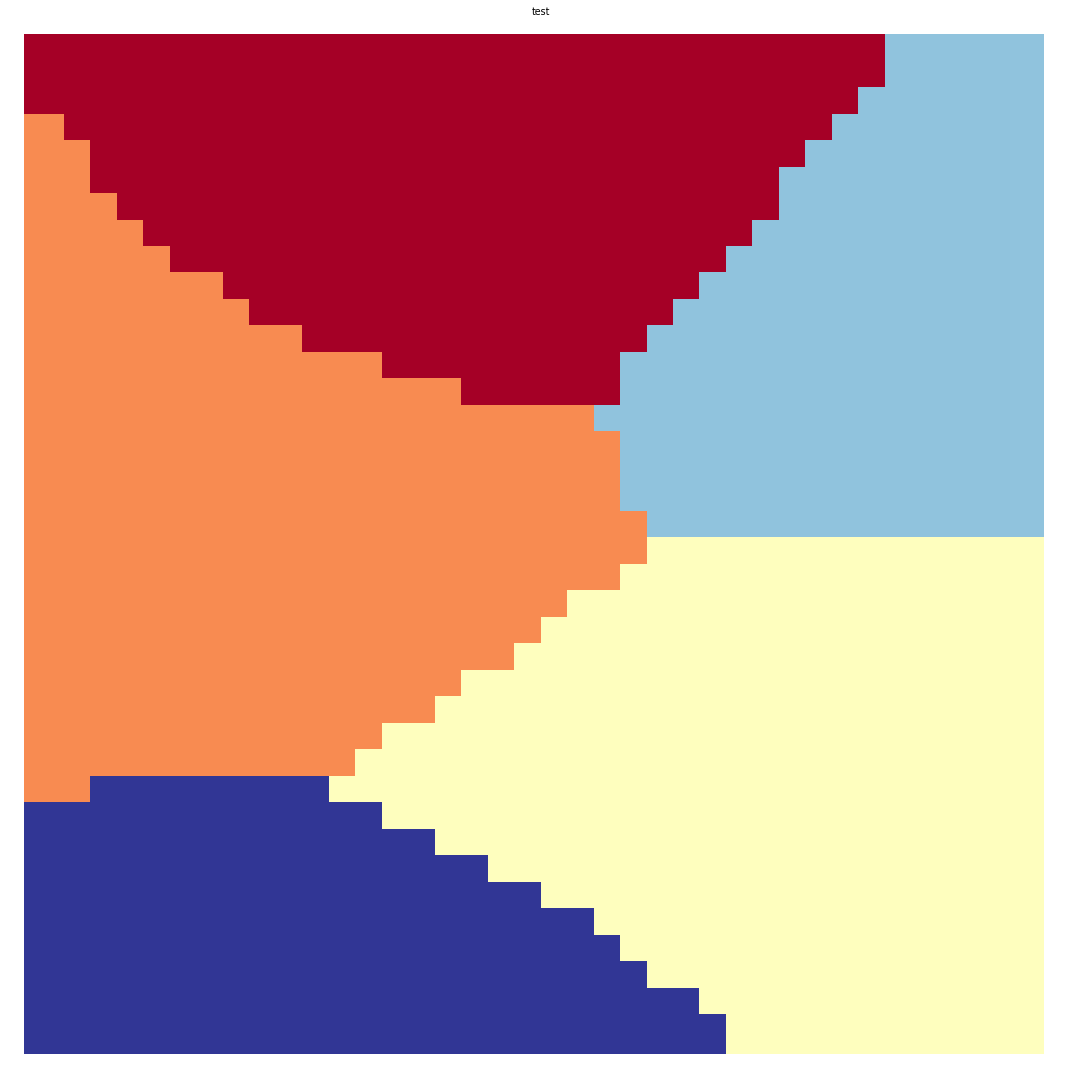

In [43]:
v.show(som, what='cluster')

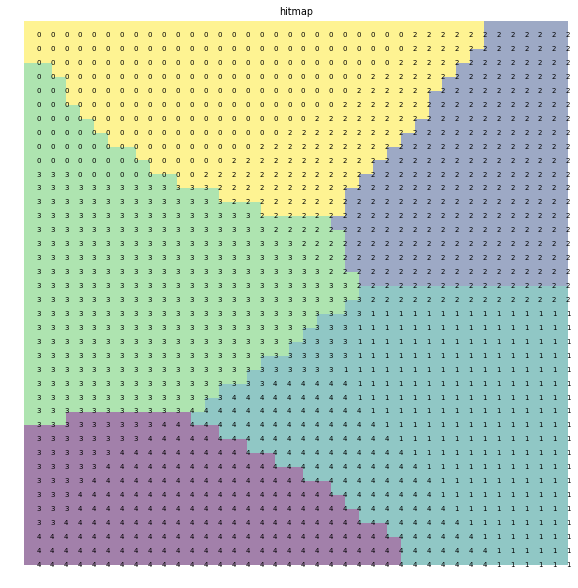

In [44]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

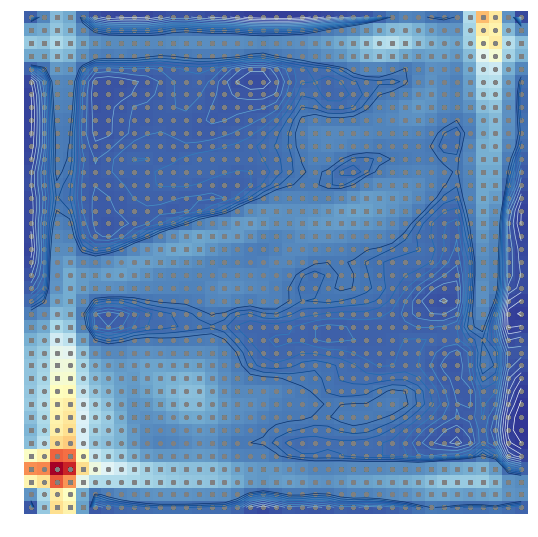

In [45]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)


# TO DO
* Interpret hitmap and u-matrix more.. pretty but what can be learned?
* Try with other combos, e.g., No Chl or log(MLD) per Landschutzer
* Perform tuning exercise to choose model with lowest error
* Validate conversion of SOM results back to cluster designation for raw data (e.g., translation of neuron results to all raw data points based on centroid/BMU value)
* Validate that "clustering" method described using k-means above, post model-build, is what we're looking for

In [46]:
%matplotlib inline
import math
import glob
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import random
import matplotlib
from sompy.sompy import SOMFactory
from sompy.visualization.plot_tools import plot_hex_map
import logging

,ylat,xlon,SSS,MLD,SST,pCO2
0,-77.5,179.5,34.000992,2.784570,1.648732,151.525853
1,-77.5,180.5,33.941429,2.715717,1.528921,150.330599
2,-77.5,181.5,33.863464,2.644176,1.350243,148.500409
3,-77.5,182.5,33.775764,2.570496,1.119088,146.198458
4,-77.5,183.5,33.691376,2.512309,0.865820,143.769723


In [48]:
import random

In [49]:
m/10

3

In [55]:
names = ['SSS','SST','MLD','pCO2']

In [ ]:
# Train the model with different parameters. The more, the better. Each iteration is stored in disk for further study 

for i in range(1): 
    sm = sompy.SOMFactory().build(ss, 
                            mapsize=[random.choice(list(range(m,10*m))), 
                                     random.choice(list(range(m,10*m)))], 
                            normalization = 'var', initialization='random', 
                            component_names=names, lattice="rect") 
    sm.train(n_job=5, 
             verbose='info', 
             train_rough_len=20, 
             train_finetune_len=50) 
    
    joblib.dump(sm, "model_{}.joblib".format(i))

In [ ]:
# Study the models trained and plot the errors obtained in order to select the best one
models_pool = glob.glob("./model*")
errors=[]
for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))
e_top, e_q = zip(*errors)

In [ ]:
plt.scatter(e_top, e_q)
plt.xlabel("Topographic error")
plt.ylabel("Quantization error")
plt.show()